<a href="https://colab.research.google.com/github/kev1092/Lab2-CV-course-HH/blob/main/Lab_2_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/kev1092/Lab2-CV-course-HH

Cloning into 'Lab2-CV-course-HH'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 76
Unpacking objects: 100% (78/78), done.


In [2]:
!pip install opencv-contrib-python==4.4.0.44

# we need to install a more updated version of opencv in order to use sift here

     |████████████████████████████████| 55.7 MB 112 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Lab 2: Feature Extraction

In computer vision, feature extraction refers to the process of compressing/abstracting the information from a given image into a reduced vector form, called feature vector.

In this lab, we will focus on object recognition applications. Virtually any object recognition application would do feature extraction in order to understand the content of the image and generate a useful set of features able to describe it as best as possible. This feature vector can then be used to recognize and identify objects in a much easier way than doing direct pixel comparison.

There are many different algorithms to do feature extraction, depending on the type of features that it focus on, texture, color, shape... etc. If it describes the image as a whole or just local information, or just different strategies for the same goal.

In this lab we will focus on two different types of feature extraction algorithms, local and global descriptors.e

## **Local Descriptors**

Local descriptors, as their name suggest, look to describe a small area of the image. In this type of descriptors we can differentiate two steps:



*   Keypoint detection: In this steps we try to identify potential location or points in the image that can contain useful information to describe an object. 
*   Local feature description: In this step we try to describe the area around the keypoint by extracting useful information like texture.

We will be analyzing one of the most common local descriptors in computer vision, Scale Invariant Feature Transform (SIFT)

### **SIFT**

Please take into account that this will be just a brief explanation on the SIFT algorithm, for more information you can refer to the original paper that you can find [here](https://www.cs.ubc.ca/~lowe/papers/iccv99.pdf) or for example, OpenCV auxiliar [documentations ](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)


SIFT is a patented algorithm (although apparently the license expired March 2020) first introduced by David G. Lowe in the paper "Lowe, D. G. (1999, September). Object recognition from local scale-invariant features. In Proceedings of the seventh IEEE international conference on computer vision (Vol. 2, pp. 1150-1157). Ieee." SIFT features are invariant to translation, scaling, rotation and partially invariant to illumination changes or affine transformation.

SIFT uses the Differentiate of Gaussians for keypoint detection, an algorithm also introduced by the same author in the same paper.

###### **Keypoint detection: Difference of Gaussians (DoG)**

DoG is used to extract "blob"-like regions. "BLOB" stands for Binary Large Object, and it is a common term within computer vision (even though some specific areas or libraries can use it to refer to slightly different things),  we call blobs to some amorphous region of pixels that share some properties, like intensity.

We saw in our previous lab that Gaussians are low pass filters, the main idea here is to use gaussians of different σ-values and subtract them together to create band-pass filter, we extend this to different resolutions of the image to detect blobs at different scales in the Gaussian pyramid, as shown in the image below


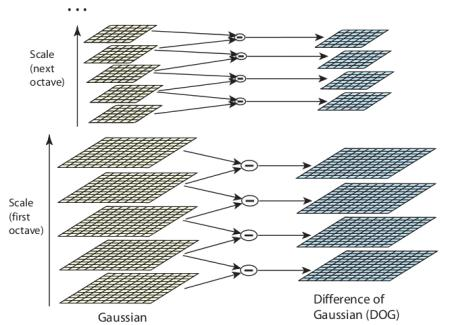

We then need to find local extrema in the DoG both in space and across different scale. We do that by checking the 26 pixel neighborhood around a pixel. We consider the 8 pixels neighborhood around a specific level of the DoG as well as the 9 pixel neighborhood of the level above and below. If that pixel contains a local maxima or minima, we mark that as a keypoint. Finally a pruning step is made to remove the low contrast keypoint.

Finally we assign a scale value to each keypoint to identify the scale level at which the keypoint is located, and an orientation is calculated based on the hightest orientation values in a weighted gradient histogram surrounding the keypoint. 

Let's see an example of this!

Text(0.5, 1.0, 'Target Image')

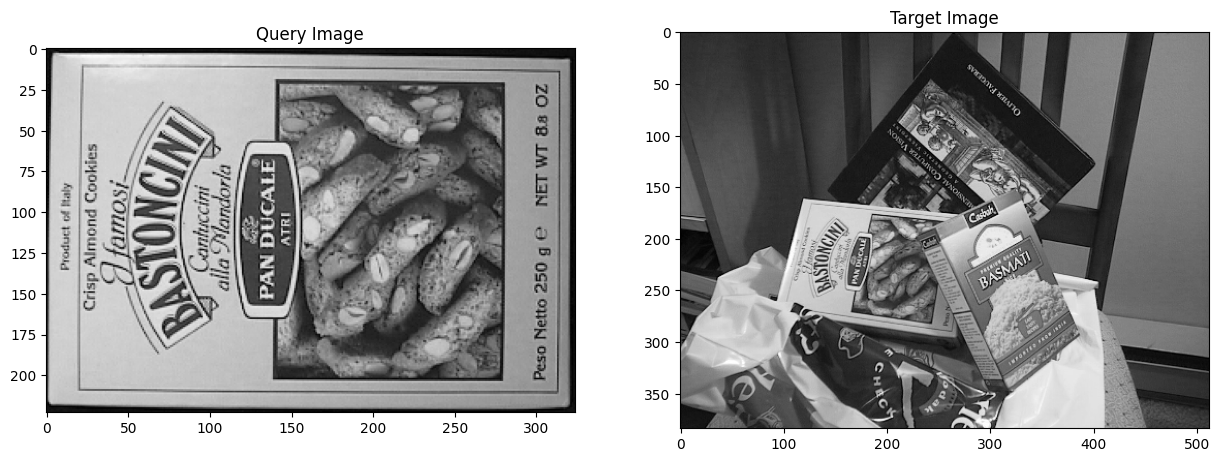

In [8]:
# let's import our two images for this part of the lab
# img_q will be the query image that we would like to recognize/detect/match in the target image

img_q = cv2.imread("Lab2-CV-course-HH/box.png",cv2.IMREAD_GRAYSCALE)
img_t = cv2.imread("Lab2-CV-course-HH/box_in_scene.png",cv2.IMREAD_GRAYSCALE)

#ok so let's check them! 

fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img_q,cmap="gray")
ax.set_title('Query Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(img_t,cmap="gray")
ax.set_title("Target Image")



As you can see in this section we will be trying to find in the target image, this box of cookies. both instances of the same object differ in scale, orientation and illumination, furthermore, the target image has some partial oclusion and a different perspective.

Now let's find our keypoints

SIFT found 604 keypoints in the query image and 969 keypoints in the target image


Text(0.5, 1.0, 'Keypoints in Target Image')

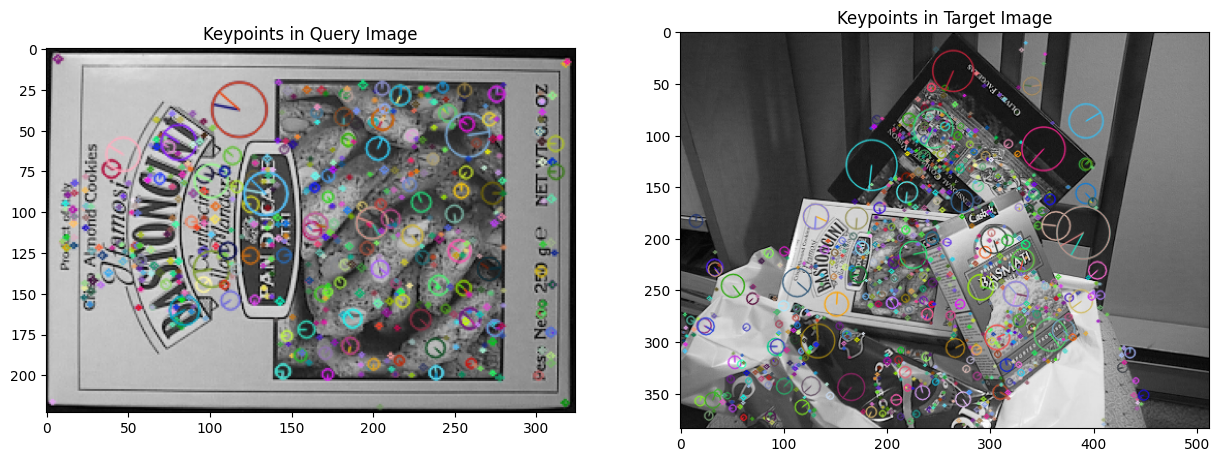

In [9]:
# we create an instance for our detector

sift = cv2.SIFT_create()

kp_q = sift.detect(img_q,None)
kp_t = sift.detect(img_t,None)

print("SIFT found {} keypoints in the query image and {} keypoints in the target image".format(len(kp_q),len(kp_t)))

# we can draw our keypoints in the images too
img_kpq = img_q.copy()
img_kpt = img_t.copy()
img_kpq = cv2.drawKeypoints(img_q,kp_q,img_kpq, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kpt = cv2.drawKeypoints(img_t,kp_t,img_kpt, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img_kpq,cmap="gray")
ax.set_title('Keypoints in Query Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(img_kpt,cmap="gray")
ax.set_title("Keypoints in Target Image")


We can see that the number of keypoints varied a lot between images, which makes sence due to the difference in size and complexity. We can also see that in both pictures the keypoint detection algorithm detected several keypoints in our cookie box. Now it begs the question.... how can we match all these different keypoints?

###### **Feature description: SIFT**

One we have the our keypoint locations, we need to create a feature vector that describes the surrounding of that pixel. For that, what SIFT does is to extract an area of 16x16 pixels, divide it in 16 regions of 4x4 and calculate the gradient information in that region. Next, it will construct an 8-bin histogram of the magnitud and orientation with the information of all pixels in that 4x4 subregion. Finally it will combine all gradient histograms to create a 4x4x8=128 feature vector.


In [10]:
# since we extracted the keypoints before, we can extract the features by calling "compute" in our sift handler
kp_q, desc_q = sift.compute(img_q,kp_q)
kp_t, desc_t = sift.compute(img_t,kp_t)

# now we have on one variable our keypoints, and their corresponding descriptor in the other.
# we can check that their sizes match and correspond to the same number of keypoints from before

print("number of keypoints in query image is {}, number of feature vectors {}, the size of each feature vector is {}".format(len(kp_q),len(desc_q),len(desc_q[0])))
print("number of keypoints in target image is {}, number of feature vectors {}, the size of each feature vector is {}".format(len(kp_t),len(desc_t),len(desc_t[0])))

# we can also take a look at how this feature vectors look like

print(desc_q[0])

number of keypoints in query image is 604, number of feature vectors 604, the size of each feature vector is 128
number of keypoints in target image is 969, number of feature vectors 969, the size of each feature vector is 128
[  0.   0.   0.   0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.
   1.  11.   1.   0.   0.   0.   0.   0.  27.  19.   0.   0.   0.   0.
   0.   0.  57.  11.  15.   0.   0.   0.   0.   0.   0.   8. 154.   2.
   0.   0.   0.   0.  18. 164.  33.   1.   0.   0.   0.   0. 164. 164.
   0.   0.   1.   0.   0.   0. 164.  56.  38.   4.   0.   0.   0.   0.
   0.   2. 164.  64.   0.   0.   0.   0.   1.  55. 154.  35.   2.   0.
   0.   0.  17.  43.   1.   6.   6.   0.   0.   0.  13.   4.  18.   2.
   0.   0.   0.   0.   0.   1. 164.  63.   0.   0.   0.   0.   0.   0.
 164.  37.   0.   0.   0.   0.   0.   0.   5.   4.   1.   0.   0.   0.
   0.   0.]


###### **keypoint matching**

Now that we have our keypoints and their associated descriptor, let's see if we can match our images!

In this lab we won't get into details into the different types of matching algorithms that there are and how they work for keypoint matching, you can find more information about Brute-Force Matcher and FLANN based Matcher [here](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

We are going to use Brute-Force Matching, which just compares all keypoints in the query image against all keypoint in the target image. How do we compare them? we can use any distance or similarity metric that we want. Then we are following Lowe's recommendation and use a ratio test between the best and second-best match for each keypoint to ensure that the match is good. A good match will have a very small ratio since the distance for the best match would be low and the distance to the second-best match would be high

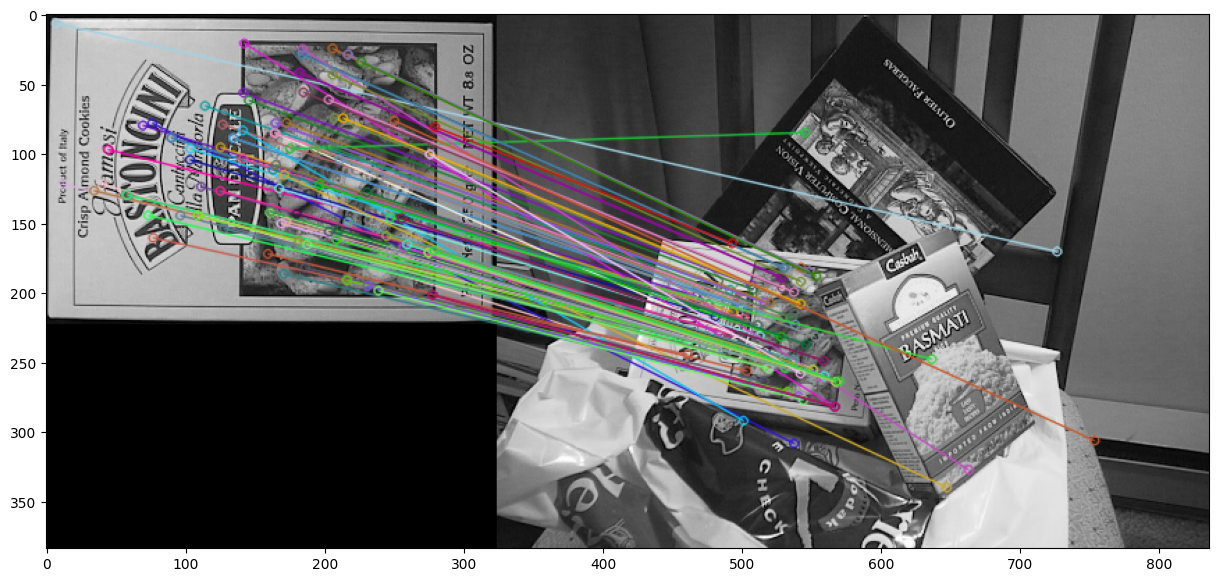

In [11]:
# we initialize our handler for the matcher algorithm
BFM = cv2.BFMatcher()

# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_q,desc_t,k=2)

valid_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        valid_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
img_match = cv2.drawMatches(img_q,kp_q,img_t,kp_t,valid_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(img_match)


We can see that some of the matches are not correct, but he vast majority seem to be fine!

Now that we have our keypoints, descriptors, and matches, what strategy do we follow for object classification? we have our query image and we can have several target images over which we need to recognize which one has the same object/identity. There are several options, we can have a threshold on the number of correct matches necessary to recognize the object. However, this strategy is very sensitive to the number of keypoints in each of the images, if because of the image we are only able to detect 10 keypoints, but all keypoints are correctly match, it is still likely to be the correct object. So, another strategy could be to normalize the number of matches with the number of keypoints present in the images. 

In [16]:
dicaprio1 = cv2.imread("Lab2-CV-course-HH/dicaprio1.jpg",cv2.IMREAD_GRAYSCALE)
dicaprio2 = cv2.imread("Lab2-CV-course-HH/dicaprio2.jpg",cv2.IMREAD_GRAYSCALE)
brad = cv2.imread("Lab2-CV-course-HH/brad.jpg",cv2.IMREAD_GRAYSCALE)

In [17]:
kp_d1, desc_d1 = sift.detectAndCompute(dicaprio1,None)
kp_d2, desc_d2 = sift.detectAndCompute(dicaprio2,None)
kp_b, desc_b = sift.detectAndCompute(brad,None)

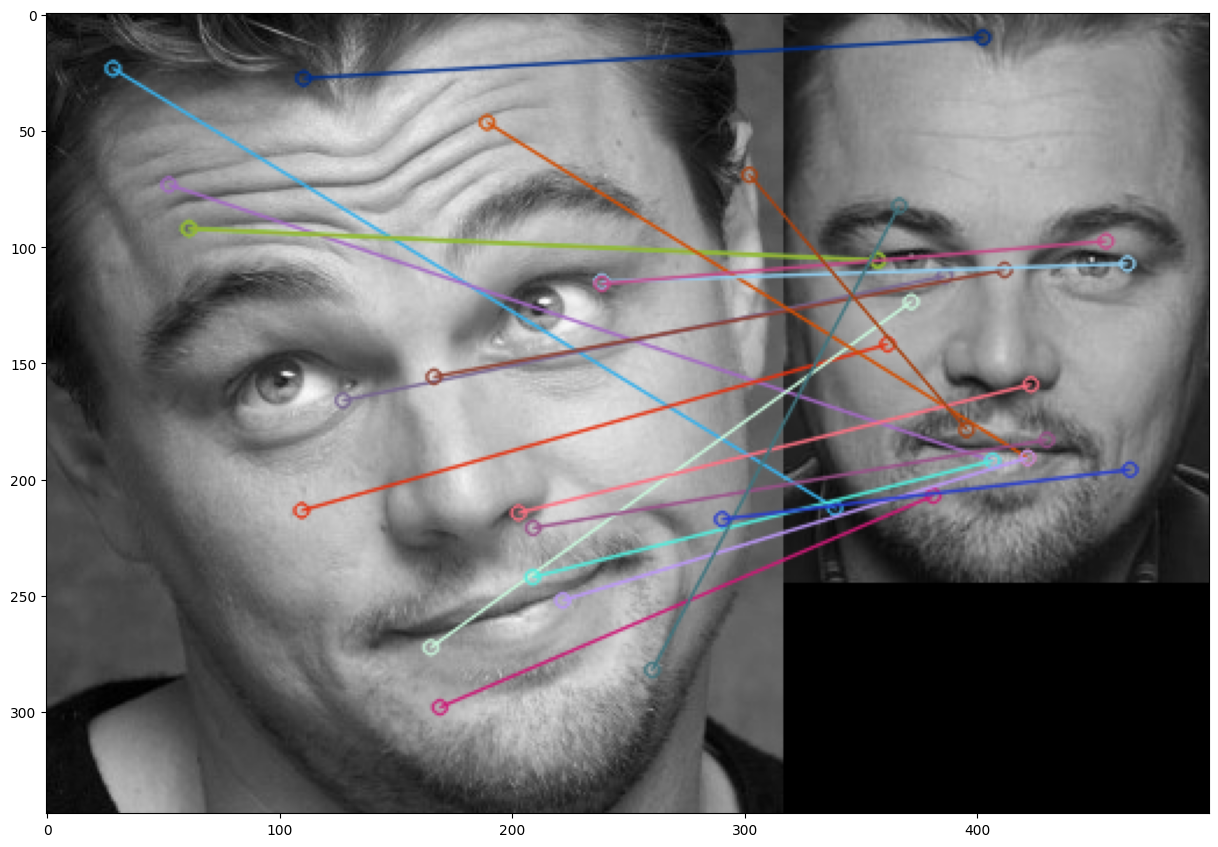

In [18]:

# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_d2,desc_d1,k=2)

dicaprio_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        dicaprio_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
dicaprio_match = cv2.drawMatches(dicaprio2,kp_d2,dicaprio1,kp_d1,dicaprio_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(dicaprio_match)

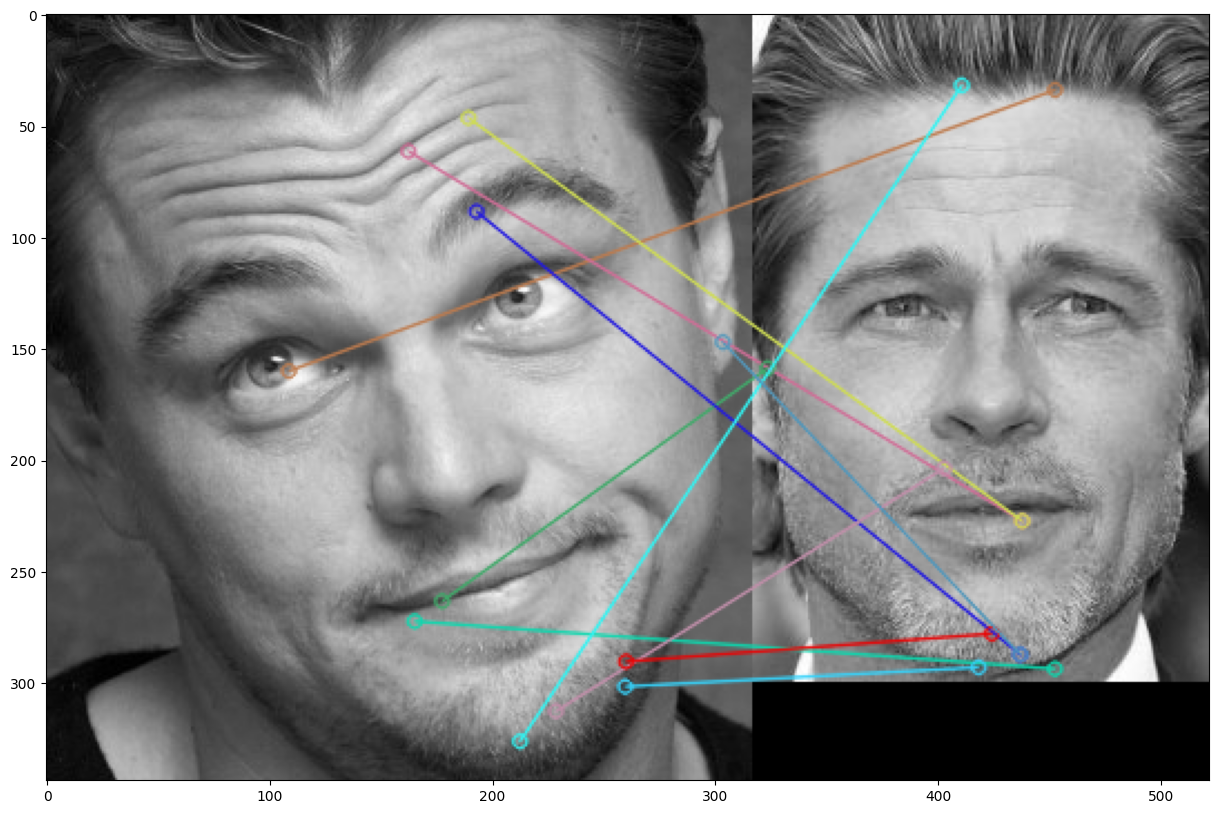

In [19]:
# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_d2,desc_b,k=2)

brad_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        brad_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
brad_match = cv2.drawMatches(dicaprio2,kp_d2,brad,kp_b,brad_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(brad_match)

In [20]:
# TO DO:

# print the number of keypoints in dicaprio1

# print the number of keypoints in dicaprio2

# print the number of keypoints in brad

# print the number of matches for dicaprio vs dicaprio

# print the number of matches between dicaprio and brad

# print the ratio of matches between dicaprios over the MINIMUM number of keypoints detected between both images

# print the ratio of matches between dicaprio and brad over the MINIMUM number of keypoints detected between both images
print(len(kp_d1))
print(len(kp_d2))
print(len(kp_b))

print(len(dicaprio_matches))
print(len(brad_matches))

print(len(dicaprio_matches)/len(kp_d1))
print(len(brad_matches)/len(kp_d2))
# take a look to OpenCV's detectAndCompute function and check that the descriptors obtained are exactly the same for both images



149
251
275
20
11
0.1342281879194631
0.043824701195219126


## Global descriptor

Global descriptors are usually applied to each pixel in the image and aim to extract information as texture in their neighborhood. After this, one could try and compare this processed image as a whole for object recognition, but they usually still suffer from things like alignment and error accumulation. For this, we try to compress all this information in a reduced vector form that can help us with the previous mentioned problems, as well as to be able to create a reduced database.

### Histogram of Oriented Gradients (HOG)

Histogram of Oriented Gradients was first introduced by Navneet Dalal and Bill Trigs in their CVPR paper ["Histograms of Oriented Gradients for Human Detection"](https://hal.inria.fr/inria-00548512/document)
in 2005.

Since this algorithm works on the extracted gradients, it is at describing textures and shapes. It is somewhat similar to SIFT descriptor in the sense that it tries to encode the local gradients around a point in histograms. For more information on HOG, you can read the original paper and/or read a more detailed explanation [here](https://learnopencv.com/histogram-of-oriented-gradients/) or in the course lectures.



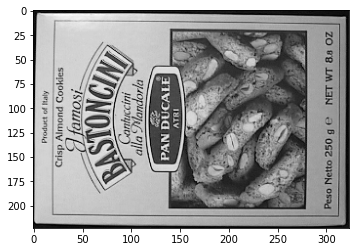

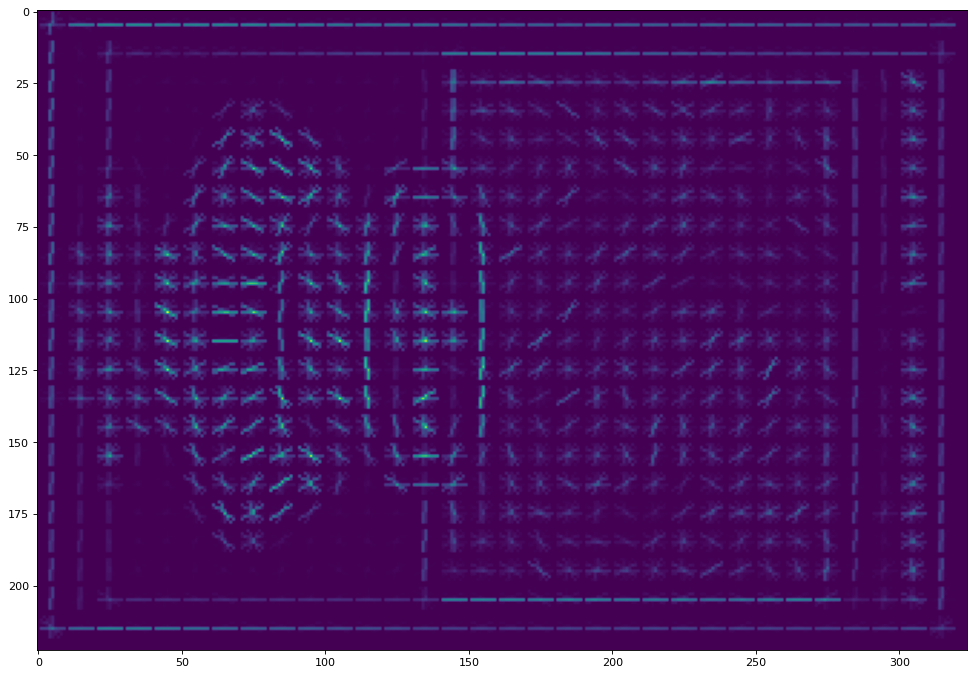

In [98]:
# we will be using the hog descriptor from skimage since it has visualization tools available for this example
from skimage import feature
from skimage import exposure

plt.imshow(img_q,cmap="gray")

# These are the usual main parameters to tune in the HOG algorithm. 
(H,Himage) = feature.hog(img_q, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2),visualize=True)

Himage = exposure.rescale_intensity(Himage, out_range=(0,255))
Himage = Himage.astype("uint8")

fig = plt.figure(figsize=(15, 12), dpi=80)
plt.imshow(Himage)



In [ ]:
# TO DO:
# These are the usual main parameters to tune in the HOG algorithm. 
# Vary these parameters and check in the plot show they affect the representation of the image

As you can see, HOG describes very well the general outline of the box's front part. This is, as we said earlier, because HOG focus on the gradient information over the image, which is great to detect lines and shapes. Furthermore, we can see in the image the dominant gradients and their intensity at each point.

HOG has traditionally been used not only for object recognition, but also for object detection. There are several approaches to achieve object detection with HOG, one simple way is to do template matching over the HOG image, but this approach even though better than direct pixel template matching, is still not accurate enough. For that, one used to pair it with an object recognition model trained to with HOG templates.

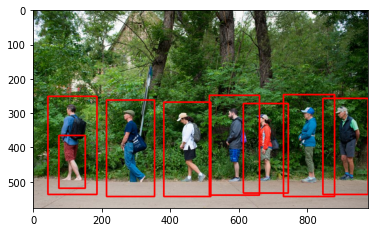

In [15]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

people_color = cv2.cvtColor(cv2.imread("Lab2-CV-course-HH/people.jpg"),cv2.COLOR_BGR2RGB)
people_gray = cv2.cvtColor(people_color,cv2.COLOR_RGB2GRAY)


bbox, weights = hog.detectMultiScale(people_gray,winStride = (2,2), padding=(10,10),scale=1.02)

# Drawing the regions in the Image
for (x, y, w, h) in bbox:
    cv2.rectangle(people_color, (x, y), 
                  (x + w, y + h), 
                  (255, 0, 0), 4)
    
plt.imshow(people_color)

In the code above we make use of OpenCV's HOG descriptor and set it's detector to be SVM and to use its default people detector. 

After importing our test image, we use the descriptor's multiscale detection method to find the persons in our image. One interesting parameter that we are passing the detectMultiScale function is the winStride. This parameter tells how many pixels/positions skip during each step during convolution. In the previous lab, in both the explanation and example, we do the convolutions over each pixel, which is the same as setting the winStride to be (1,1), advance 1 position in each coordinate axis. This time we set it to skip 1 position each time. This will affect the detectors accuracy but will greatly help the speed and computation of the process, which is one of the main issues during object detection since it is a very expensive process. You can read more about the detectMultiScale and hyperparemeters options [here](https://pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/)

We can see though that even though we do effectively detect all people in the scene, it is not perfect, since there appears a False Positive detection, the lower body of the first person is detected as another person. One way to solve this issue is to use an algorithm called Non-Maxima-Suppresion (NMS), which focus is to remove overlapping bounding boxes due to multiple detection of the same instance. This algorithm isn't perfect either of course, and a bad configuration can produce False Negatives, meaning a failure to detect an instance of an object in the scene.

In the following code we will use HOG for object recognition/classification problem. We will use three different face images for this example. These images were taken from the [Labelled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/). 


Text(0.5, 1.0, 'FaceB1')

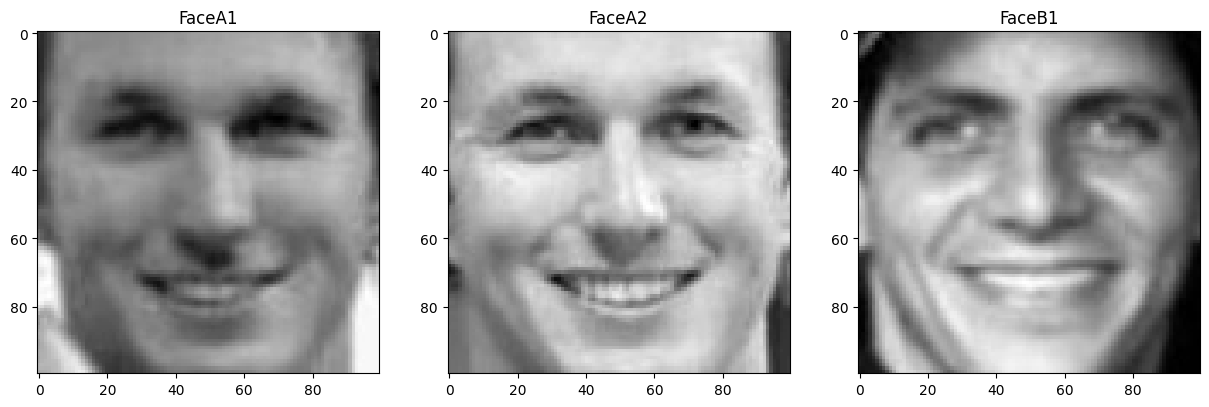

In [20]:
# we import the images
faceA1 = cv2.imread("Lab2-CV-course-HH/faceA1.jpg",cv2.IMREAD_GRAYSCALE)
faceA2 = cv2.imread("Lab2-CV-course-HH/faceA2.jpg",cv2.IMREAD_GRAYSCALE)
faceB1 = cv2.imread("Lab2-CV-course-HH/faceB1.jpg",cv2.IMREAD_GRAYSCALE)

# we extract the feature vectors
HA1 = feature.hog(faceA1, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))
HA2 = feature.hog(faceA2, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))
HB1 = feature.hog(faceB1, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2))

# Let's plot our images:
fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 3, 1)
plt.imshow(faceA1,cmap="gray")
ax.set_title('FaceA1')
ax = fig.add_subplot(1,3,2)
plt.imshow(faceA2,cmap="gray")
ax.set_title("FaceA2")
ax = fig.add_subplot(1,3,3)
plt.imshow(faceB1,cmap="gray")
ax.set_title("FaceB1")

After extracting the feature vectors we can use them to compare the images. But let's check the difference in sizes and distances when comparing images directly and extract features using HOG

In [118]:
print("images shape: {}".format(faceA1.shape))
print("feature vector size: {}".format(len(HA1)))

distA_I = np.sqrt(np.sum((faceA1-faceA2)**2))
distB_I = np.sqrt(np.sum((faceA1-faceB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_I))
print("pixel-wise distance between different persons: {} ".format(distB_I))

distA = np.sqrt(np.sum((HA1 - HA2)**2))
distB = np.sqrt(np.sum((HA1 - HB1)**2))
print("distance between feature vectors from the same person: {}".format(distA))
print("distance between feature vectors from different persons: {}".format(distB))

print("The distance between different persons is {} times the distance between same person for direct pixel comparison".format(distB_I/distA_I))
print("The distance between different persons is {} times the distance between same person for HOG".format(distB/distA))

images shape: (100, 100)
feature vector size: 2916
pixel-wise distance between same person: 1065.824563424957 
pixel-wise distance between different persons: 1031.6016673115646 
distance between feature vectors from the same person: 4.2594823848012995
distance between feature vectors from different persons: 6.491350145746221
The distance between different persons is 0.9678906854957261 times the distance between same person for direct pixel comparison
The distance between different persons is 1.5239762861583088 times the distance between same person for HOG


Here we can see different things. We can see the huge difference in the distance metric when directly comparing two different images and when comparing feature vectors, from +1000 to units distance. One of the reasons for increment in distance is, of course, the difference in size between vectors/matrices, but other reasons like normalization (that HOG does) can also reduce the total distance. Moreover, we also see that, the difference in distance from the same-person and different-person when doing pixel comparison is much lower (in comparison to the global distance) than with HOG, this will affect the accuracy of the future recognition model. Finally, another thing that we can see, and most important, is that the distance between different persons is actually lower when doing direct comparison! But this effect is actually fixed when processing the images by extracting the features from the image. If we would not do HOG, we would missclasify and recognize the image as being another person!

In [ ]:
# TO DO:
# Vary the parameters from HOG and check how they affect the size of the feature vectors and the distance between the images

### Local Binary Patterns (LBP)

Local Binary Pattern is a local texture description algorithm first introduced in "Ojala, T., Pietikainen, M., & Harwood, D. (1994, October). Performance evaluation of texture measures with classification based on Kullback discrimination of distributions. In Proceedings of 12th international conference on pattern recognition (Vol. 1, pp. 582-585). IEEE.". Again, the same as with HOG, we apply these descriptor localy, but throughout the whole image, in comparison to local feature algorithm like SIFT, were we only do it around specific keypoint.

LBP describes the pixel intensity relation between the center pixel and the pixel around it to find edges, spots, lines or constant areas. it can also encode the orientation of these features, although rotation invariance options are available. We can then summarize this information in histograms that describes the texture of subsections of the image/object.

So let's see the algorithm at work!

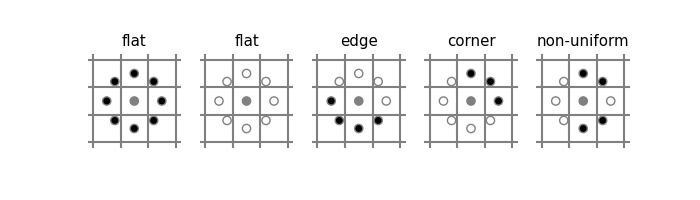

for more information about the parameter and an example of LBP for texture classification visit [here](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=local_binary_pattern#skimage.feature.local_binary_pattern) and [here ](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py) from the official scikit-image library.

The only configuration parameters that the function takes are:

*   nPoints: number of points to divide the circle around the pixel
*   Radius: radius of the circle
*   method: selection of strategies to follow, for example algorithm modification to achieve rotation invariance, gray scale invariance...






Text(0.5, 1.0, 'Texture image')

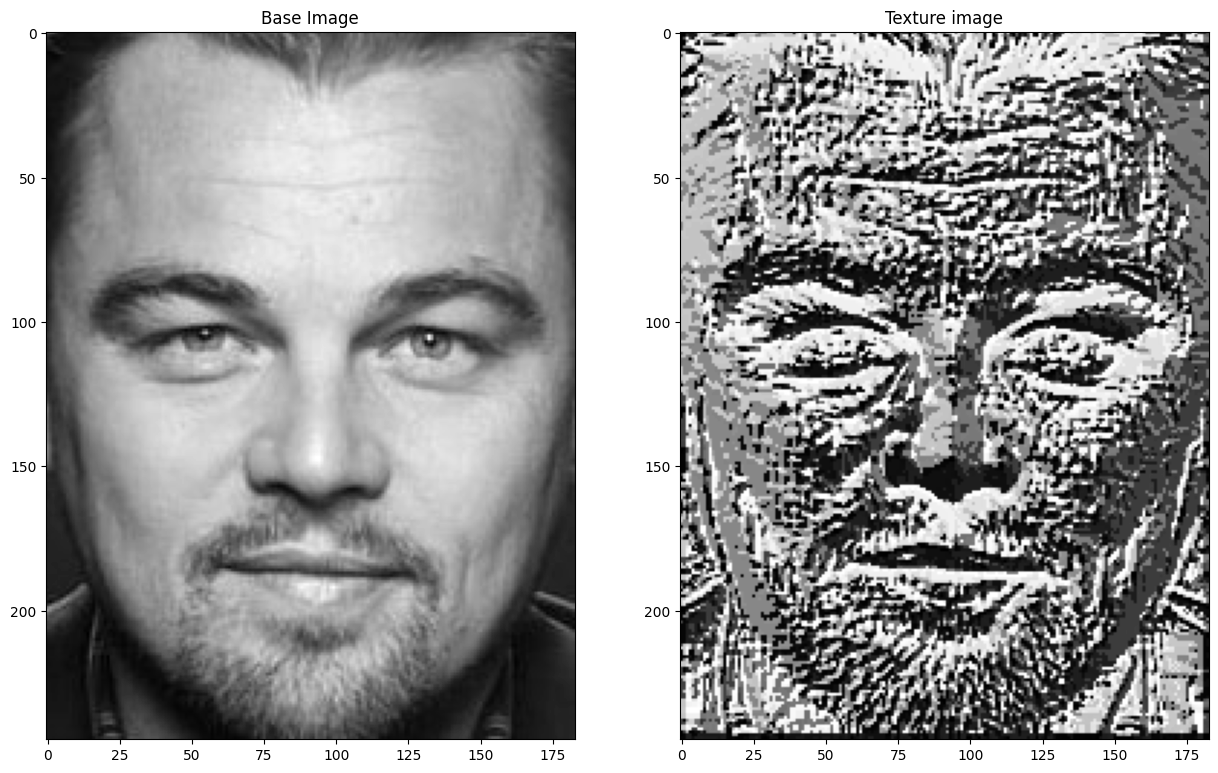

In [31]:
# we will use again skimage library for this algorithm

nPoints = 8
radius = 2
lbp = feature.local_binary_pattern(dicaprio1, nPoints, radius, method="default")

# Let's take a look at how our image looks
fig = plt.figure(figsize=(15, 12), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.imshow(dicaprio1,cmap="gray")
ax.set_title('Base Image')
ax = fig.add_subplot(1,2,2)
plt.imshow(lbp,cmap="gray")
ax.set_title("Texture image")

# TO DO: change the parameters and analyze how they affect the output image

However, we got an image back instead of a feature vector. We could compare directly this texture image. Let's do this with our aligned face images from the LFW dataset acd check the performance

In [97]:
nPoints = 24
radius = 2
lbp_FA1 = feature.local_binary_pattern(faceA1, nPoints, radius, method="default")
lbp_FA2 = feature.local_binary_pattern(faceA2, nPoints, radius, method="default")
lbp_FB1 = feature.local_binary_pattern(faceB1, nPoints, radius, method="default")

distA_I = np.sqrt(np.sum((faceA1-faceA2)**2))
distB_I = np.sqrt(np.sum((faceA1-faceB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_I))
print("pixel-wise distance between different persons: {} ".format(distB_I))

distA_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FA2)**2))
distB_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_LBP))
print("pixel-wise distance between different persons: {} ".format(distB_LBP))

pixel-wise distance between same person: 1065.824563424957 
pixel-wise distance between different persons: 1031.6016673115646 
pixel-wise distance between same person: 731722519.3710771 
pixel-wise distance between different persons: 919589024.1143999 


We can see that even though the distance value has increased a lot respect to direct pixel comparison, now the pictures from the same person would have been correctly recognized! Also, the gap between same-person comparison and different-person comparison has widen a lot! 

However, comparing large matrices are not ideal, distance between high dimensional data is not great, and they are heavily affected by things like alignment, scale and orientation (Even though our images are aligned, and normalized in scale and orientation). That is why a common approach is to use histograms, similar to HOG, to create our feature vector. This approach is commonly refered as LBPH

In [111]:
# we create a histogram of the lbp values
bin_size = 2049
lbph_A1,_ = np.histogram(lbp_FA1, bins = np.arange(0,bin_size), density=True)
# Let's take a look at the feature vector
print(lbph_A1)

[0.22106632 0.01950585 0.         ... 0.         0.04161248 0.15214564]


In [115]:
# Now let's compare our images' feature vectors with euclidean distance
lbph_FA1,_ = np.histogram(lbp_FA1, bins = np.arange(0,bin_size), density=True)
lbph_FA2,_ = np.histogram(lbp_FA2, bins = np.arange(0,bin_size), density=True)
lbph_FB1,_ = np.histogram(lbp_FB1, bins = np.arange(0,bin_size), density=True)

distA_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FA2)**2))
distB_LBP = np.sqrt(np.sum((lbp_FA1-lbp_FB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_LBP))
print("pixel-wise distance between different persons: {} ".format(distB_LBP))

distA_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FA2)**2))
distB_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_LBPH))
print("pixel-wise distance between different persons: {} ".format(distB_LBPH))

print("The distance between different persons is {} times the distance between same person for LBP".format(distB_LBP/distA_LBP))
print("The distance between different persons is {} times the distance between same person for LBPH".format(distB_LBPH/distA_LBPH))

pixel-wise distance between same person: 731722519.3710771 
pixel-wise distance between different persons: 919589024.1143999 
pixel-wise distance between same person: 0.09171556276422146 
pixel-wise distance between different persons: 0.14293579825809807 
The distance between different persons is 1.2567455555485652 times the distance between same person for LBP
The distance between different persons is 1.5584683117035596 times the distance between same person for LBPH


We can see that we have increase the distance relation between different and same person, so LBPH should work better.

However, this is just a simple implementation of LBPH, the most common approach is to follow a similar procedure as HOG where we divide the image in subregions via a grid, compute the histograms in each of those blocks or areas and then compare the feature vector obtain from all histograms.

# **HOMEWORK**

BESIDES completing the "TO DO" sections in the lab, you must do the following as homework:

Repeat the SIFT exercise but changing the keypoint detection strategies and the descriptor. USE BRISK for keypoint detection and ORB as local descriptor.

Show keypoints detected and matches for all the images (dicaprio1, dicaprio2 and brad)

Compute the same metrics as before in the sift exercise: number of keypoints detected, number of matches in each comparison, and the ratio of matches over minimum number of keypoints detected form both images (if image A has 3 keypoints and image B has 10 keypoints and there is only 1 succesful match, the ratio would be 1/3).

you can see a tutorial on ORB in opencv [here](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html). You can create a BRISK object in the same way as with ORB. by doing cv2.BRISK_create()

You can combine different keypoint and descriptors to your like. (although OpenCV has some issues with some of these combinations)

Which perform best, according to the calculated metrics, SIFT or BRISK/ORB?

In [102]:
nPoints = 24
radius = 2
lbp_FA1 = feature.local_binary_pattern(dicaprio1, nPoints, radius, method="default")
lbp_FA2 = feature.local_binary_pattern(dicaprio2, nPoints, radius, method="default")
lbp_FB1 = feature.local_binary_pattern(brad, nPoints, radius, method="default")


bin_size=512
# Now let's compare our images' feature vectors with euclidean distance
lbph_FA1,_ = np.histogram(lbp_FA1, bins = np.arange(0,bin_size), density=True)
lbph_FA2,_ = np.histogram(lbp_FA2, bins = np.arange(0,bin_size), density=True)
lbph_FB1,_ = np.histogram(lbp_FB1, bins = np.arange(0,bin_size), density=True)


distA_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FA2)**2))
distB_LBPH = np.sqrt(np.sum((lbph_FA1-lbph_FB1)**2))
print("pixel-wise distance between same person: {} ".format(distA_LBPH))
print("pixel-wise distance between different persons: {} ".format(distB_LBPH))


print("The distance between different persons is {} times the distance between same person for LBPH".format(distB_LBPH/distA_LBPH))

pixel-wise distance between same person: 0.03023758418932961 
pixel-wise distance between different persons: 0.084765072585934 
The distance between different persons is 2.8033017470967914 times the distance between same person for LBPH


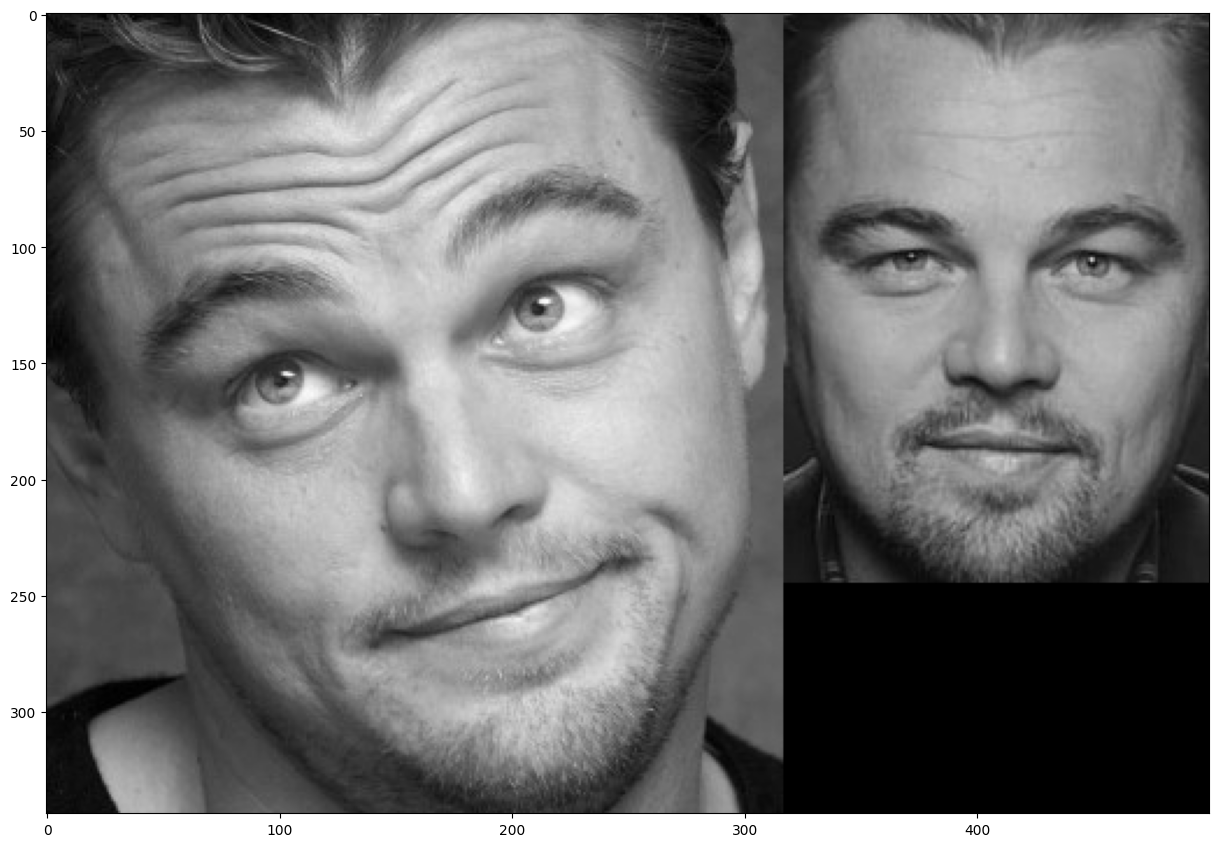

In [96]:
orb = cv2.ORB_create()

kp1 = orb.detect(dicaprio1,None)
kp2 = orb.detect(dicaprio2,None)

brisk = cv2.BRISK_create()
kp_d1,desc_d1 = brisk.compute(dicaprio1,kp1)
kp_d2,desc_d2 = brisk.compute(dicaprio2,kp2)
# we find the matches between our two descriptors and extract the 2 best matches for Lowe's ratio test
matches = BFM.knnMatch(desc_d2,desc_d1,k=2)

dicaprio_matches = []

for ImageA,ImageB in matches:
    if ImageA.distance < 0.8*ImageB.distance:
        dicaprio_matches.append(ImageA)

# we can finally draw our keypoint matches between our query and target image!
dicaprio_match = cv2.drawMatches(dicaprio2,kp_d2,dicaprio1,kp_d1,dicaprio_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig = plt.figure(figsize=(15, 12), dpi=100)
plt.imshow(dicaprio_match)

Enlaces/gracias: https://www.geeksforgeeks.org/pedestrian-detection-using-opencv-python/

https://debuggercafe.com/opencv-hog-hyperparameter-tuning-for-accurate-and-fast-person-detection/

https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/#:~:text=The%20HOG%20feature%20descriptor%20counts,called%20hog%20in%20the%20skimage.